<a href="https://colab.research.google.com/github/Gooogr/Keras_Fast_Style_Transfer/blob/master/Autoencoder_without_pooling_layers_from_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is testing autoencoder`s architecture from the article "Perceptual Losses for Real-Time Style Transfer and Super-Resolution".

Other parts of autoencoder will be as simple as possible.

Simple autoencoder: https://blog.keras.io/building-autoencoders-in-keras.html <br>
Original article: https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf <br>
Supplementary material: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf

How to use tensorboard in google collab: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab<br>


In [13]:
!pip install tensorboardcolab

In [0]:
# from keras import models
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

from keras import layers
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D 
from keras.layers import BatchNormalization, ReLU

from keras.models import Model
from keras import backend as K

from keras.datasets import mnist

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import numpy as np

import matplotlib.pyplot as plt

### Simple MNIST CNN autoencoder

In [3]:
input_img = Input(shape = (28, 28, 1))

x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 1s 0us/step


In [21]:
# set up tensorboard
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://4e3abcb8.ngrok.io


In [22]:
autoencoder.fit(x_train, x_train,
                batch_size = 128,
                epochs = 50,
                shuffle = True,
                verbose = 10,
                validation_data = (x_test, x_test),
                callbacks = [TensorBoardColabCallback(tbc)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


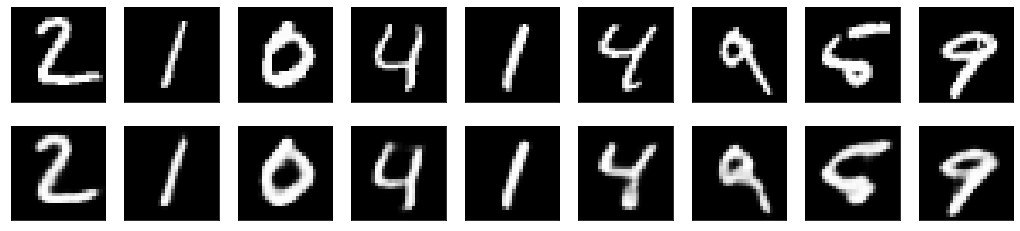

In [27]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Non-pooling autoencoder from article

Residual block: https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64 <br>
In our case shortcut will be simple, without conv layer (due to article) and we will use ReLU instead of LeakyReLU. 

In [0]:
def residual_block(y, nb_channels, _strides = (1, 1)):
  shortcut = y

  #forward pass
  y = Conv2D(nb_channels, kernel_size = (3, 3), strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)
  y = ReLU()(y)

  y = Conv2D(nb_channels, kernel_size = (3, 3), strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU()(y)

  return y

In [59]:
input_img = Input(shape = (256, 256, 3))

x = Conv2D(32, (9, 9), strides = 1, activation = 'relu', padding = 'same')(input_img)
x = Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
print('Shape after encoding:', x.shape)

x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
print('Shape after residual blocks:', x.shape)

x = Conv2DTranspose(64, (3, 3), strides = 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides = 2, activation='relu', padding='same')(x)
decoded = Conv2DTranspose(3, (9, 9), strides = 1, activation='relu', padding='same')(x) #may be sigmoid function?
print('Shape after decoding:', decoded.shape)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Shape after encoding: (?, 64, 64, 128)
Shape after residual blocks: (?, 64, 64, 128)
Shape after decoding: (?, ?, ?, 3)


We will use colorful MNIST (only "4"). Source link: https://www.kaggle.com/prasunroy/synthetic-digits/download <br>
Using datagenerator with autoencoder: https://github.com/keras-team/keras/issues/3923

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
train_dir = '/content/drive/My Drive/datasets/colorful_4/dummy_train'
val_dir = '/content/drive/My Drive/datasets/colorful_4/dummy_validation'
test_dir = '/content/drive/My Drive/datasets/colorful_4/dummy_test'

In [0]:
# import os
# os.listdir(train_dir)

In [0]:
#create data generators templates for our dataset

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [132]:
# create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = None)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = None)

Found 800 images belonging to 1 classes.
Found 150 images belonging to 1 classes.


In [133]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://53daf9b9.ngrok.io


In [0]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [135]:
autoencoder.fit_generator(fixed_generator(train_generator),
                steps_per_epoch = 100,
                validation_steps = 50,
                nb_epoch = 10,
                validation_data = fixed_generator(validation_generator),
                callbacks = [TensorBoardColabCallback(tbc)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=100, validation_steps=50, validation_data=<generator..., callbacks=[<tensorbo..., epochs=10)`
  


Epoch 1/10
100/100 [==============================] - 310s 3s/step - loss: 0.6282 - val_loss: 0.6508
Epoch 2/10
100/100 [==============================] - 124s 1s/step - loss: 0.6010 - val_loss: 0.8728
Epoch 3/10
100/100 [==============================] - 124s 1s/step - loss: 0.5792 - val_loss: 0.6730
Epoch 4/10
100/100 [==============================] - 124s 1s/step - loss: 0.5665 - val_loss: 0.8065
Epoch 5/10
100/100 [==============================] - 124s 1s/step - loss: 0.5581 - val_loss: 0.5716
Epoch 6/10
100/100 [==============================] - 124s 1s/step - loss: 0.5551 - val_loss: 0.5776
Epoch 7/10
100/100 [==============================] - 124s 1s/step - loss: 0.5524 - val_loss: 0.5337
Epoch 8/10
100/100 [==============================] - 124s 1s/step - loss: 0.5538 - val_loss: 0.7318
Epoch 9/10
100/100 [==============================] - 124s 1s/step - loss: 0.5444 - val_loss: 0.5349
Epoch 10/10
100/100 [==============================] - 124s 1s/step - loss: 0.5424 - val_lo

In [0]:
#save results
json_model = autoencoder.to_json()

save_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer'
with open(os.path.join(save_dir, 'autoencoder.json'), 'w') as json_file:
  json_file.write(json_model)

autoencoder.save(os.path.join(save_dir, 'autoencoder_weights.h5'))

In [151]:
#test results
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = None)

Found 50 images belonging to 1 classes.


(1, 256, 256, 3)
(1, 256, 256, 3)


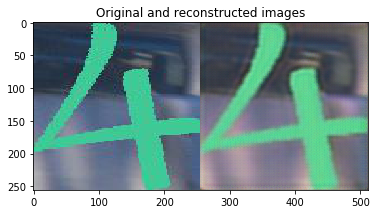

(1, 256, 256, 3)
(1, 256, 256, 3)


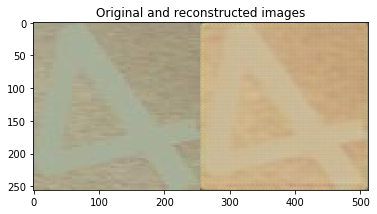

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(1, 256, 256, 3)


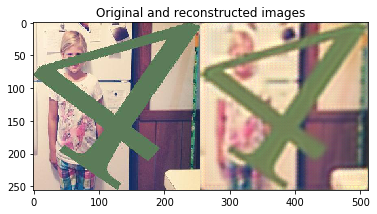

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(1, 256, 256, 3)


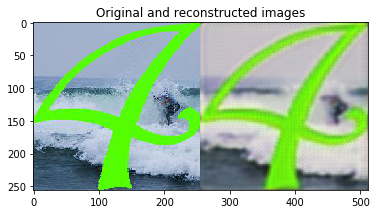

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(1, 256, 256, 3)


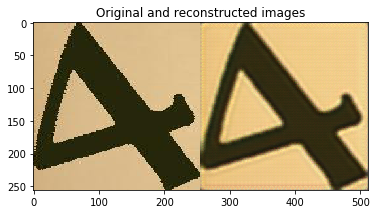

In [152]:
for dummy_i in range(5):
  test_img = next(test_generator)[:1]
  print(test_img.shape)

  dec = autoencoder.predict(test_img)
  print(dec.shape)

  plt.imshow(np.hstack((test_img[0], dec[0])))
  plt.title('Original and reconstructed images')
  plt.show()